In [7]:
import pandas as pd
import numpy as np

# ================================
# SPESIFIKASI GEJALA & PENYAKIT
# ================================
# Penyakit: Demam Berdarah (1 = Positif, 0 = Negatif)
gejala_dbd = {
    'Demam_Tinggi': 0.95,     # Gejala utama (hampir selalu ada)
    'Sakit_Kepala': 0.85,      # Sakit kepala berat
    'Nyeri_Otot': 0.75,        # Nyeri otot/sendi parah
    'Ruam_Kulit': 0.65,        # Bintik merah di kulit
    'Mual_Muntah': 0.60,       # Gangguan pencernaan
    'Pendarahan': 0.45,        # Mimisan/gusi berdarah
    'Trombositopenia': 0.70    # Jumlah trombosit rendah (dideteksi tes)
}

# Gejala pada non-DBD (penyakit lain/random)
gejala_normal = {
    'Demam_Tinggi': 0.20,
    'Sakit_Kepala': 0.40,
    'Nyeri_Otot': 0.25,
    'Ruam_Kulit': 0.05,
    'Mual_Muntah': 0.15,
    'Pendarahan': 0.02,
    'Trombositopenia': 0.10
}

# ================================
# GENERATE DATASET (100 PASIEN)
# ================================
np.random.seed(2023)
n_samples = 100
gejala_names = list(gejala_dbd.keys())
data = []

for _ in range(n_samples):
    # Tentukan status DBD (30% positif, 70% negatif)
    is_dbd = np.random.choice([1, 0], p=[0.3, 0.7])

    # Generate gejala berdasarkan status DBD
    gejala_values = []
    for gejala in gejala_names:
        if is_dbd:
            prob = gejala_dbd[gejala]
        else:
            prob = gejala_normal[gejala]
        gejala_values.append(np.random.binomial(1, prob))

    data.append(gejala_values + [is_dbd])

# Buat DataFrame
columns = gejala_names + ['Demam_Berdarah']
df = pd.DataFrame(data, columns=columns)

# ================================
# SIMPAN KE CSV
# ================================
df.to_csv('dataset_demam_berdarah.csv', index=False)
print("Dataset 100 pasien Demam Berdarah berhasil dibuat!")
print(f"Jumlah kasus positif: {df['Demam_Berdarah'].sum()}")

Dataset 100 pasien Demam Berdarah berhasil dibuat!
Jumlah kasus positif: 31


## **Tugas Penambangan Data**

DataFrame setelah konversi boolean:
   Demam_Tinggi  Sakit_Kepala  Nyeri_Otot  Ruam_Kulit  Mual_Muntah  \
0          True         False       False       False        False   
1         False         False       False       False        False   
2         False         False       False       False        False   
3          True          True        True        True        False   
4         False          True        True       False        False   

   Pendarahan  Trombositopenia  Demam_Berdarah  
0       False            False           False  
1       False            False           False  
2       False            False           False  
3        True            False            True  
4       False            False           False  

Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Demam_Tinggi     100 non-null    boo

/tmp/ipython-input-9-1869608674.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


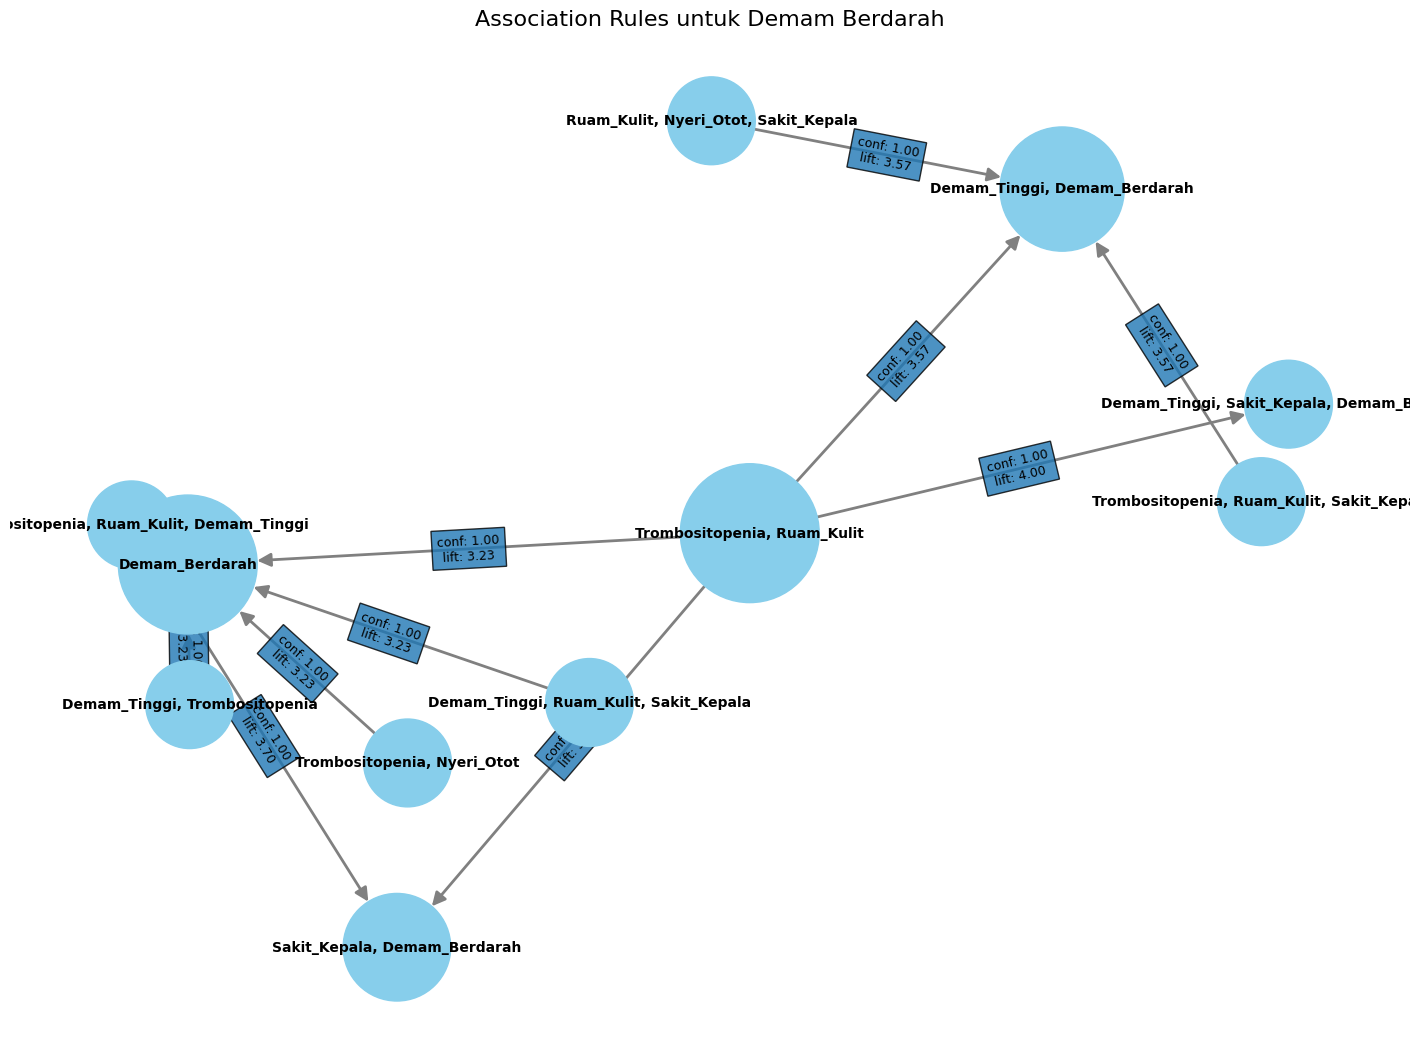

In [9]:
# STEP 1: Install library (jika belum terinstall)
# !pip install mlxtend networkx matplotlib --quiet

# STEP 2: Import library
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import matplotlib.pyplot as plt

# STEP 3: Load dataset Demam Berdarah
data = pd.read_csv('dataset_demam_berdarah.csv')

# Konversi semua nilai menjadi boolean (True/False)
df_bool = data.astype(bool)

# Tampilkan beberapa baris pertama untuk verifikasi
print("DataFrame setelah konversi boolean:")
print(df_bool.head())
print("\nInfo DataFrame:")
print(df_bool.info())

# STEP 4: Apriori Algorithm
# Menyesuaikan min_support dan min_threshold untuk dataset medis
frequent_itemsets = apriori(df_bool, min_support=0.15, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Filter rules untuk lift > 1 dan fokus pada aturan yang mengarah ke Demam Berdarah
rules_filtered = rules[
    (rules['lift'] > 1) &
    (rules['consequents'].apply(lambda x: 'Demam_Berdarah' in x))
].sort_values(by=['confidence', 'lift'], ascending=[False, False])

# Tampilkan aturan yang ditemukan
print("\nAssociation Rules (Demam Berdarah):\n")
print(rules_filtered[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
# Simpan hasil aturan asosiasi ke file CSV
rules_filtered[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_csv('Association Rules (Demam Berdarah).csv', index=False)


# STEP 5: Visualisasi Association Rules
# Buat graf asosiasi dari aturan yang sudah difilter
G = nx.DiGraph()

# Ambil hanya beberapa aturan teratas untuk visualisasi
top_rules = rules_filtered.head(10)

if not top_rules.empty:
    for _, row in top_rules.iterrows():
        antecedent_items = ', '.join([f"{item}" for item in list(row['antecedents'])])
        consequent_items = ', '.join([f"{item}" for item in list(row['consequents'])])

        label = f"conf: {row['confidence']:.2f}\nlift: {row['lift']:.2f}"
        G.add_edge(antecedent_items, consequent_items, label=label)

    # Posisi node
    pos = nx.spring_layout(G, seed=42, k=1.0, iterations=50)
    plt.figure(figsize=(14, 10))

    # Ukuran node berdasarkan degree
    node_sizes = [2000 * (G.degree(node) + 1) for node in G.nodes()]

    nx.draw(G, pos, with_labels=True,
            node_color='skyblue',
            node_size=node_sizes,
            font_size=10,
            font_weight='bold',
            edge_color='gray',
            width=2.0,
            arrowsize=20)

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                 font_size=9,
                                 bbox=dict(alpha=0.8))

    plt.title("Association Rules untuk Demam Berdarah", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('association_rules_demam_berdarah.png', dpi=300)
    plt.show()
else:
    print("\nTidak ada aturan yang ditemukan dengan parameter filter yang diberikan.")